## 1. Prepare data

In [1]:
from utils.make_txt import make_txt

make_txt(10000)

test.txt: 2000
val.txt: 2500
train.txt: 5500


## 2. Train

In [ ]:
import os
import itertools
import torch
import torch.nn as nn


from torch.utils.data import DataLoader, ConcatDataset
from torch.optim.lr_scheduler import CosineAnnealingLR, MultiStepLR

from utils.misc import str2bool, freeze_net_layers, store_labels

from ssd.ssd import MatchPrior
from ssd.vgg_ssd import create_vgg_ssd
from ssd.config import vgg_ssd_config
from ssd.data_preprocessing import TrainAugmentation, TestTransform

from datasets.COCO_dataset import COCODataset

from nn.multibox_loss import MultiboxLoss

from train_and_test import train, test

print('Single Shot MultiBox Detector Training With Pytorch')

dataset_type = "COCO"
datasets = "/home/taeho/data/coco2014"
validation_dataset = "/home/taeho/data/coco2014"
net = "vgg16-ssd"

# Params for SGD
lr = 1e-3 #1e-3
momentum = 0.9
weight_decay = 5e-4
gamma = 0.1
base_net_lr = None
extra_layers_lr = None

# Params for loading pretrained basenet or checkpoints.
base_net = "models/vgg16_reducedfc.pth"
pretrained_ssd = None
resume = "models/vgg16-ssd-Epoch-40-Loss-7.56096.pth"

# Scheduler
scheduler = "multi-step"

# Params for Multi-step Scheduler
milestones = "120,160"

# Params for Cosine Annealing
t_max = 120.0

# Train params
batch_size = 8 #24
num_epochs = 50 #100
num_workers = 4
validation_epochs = 1
debug_steps = 100
use_cuda = True
use_multi_gpu = False
checkpoint_folder = 'models/'
#num_training_loss = 0 #in train_and_test.py


if use_cuda and torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    print("Use Cuda.")
    DEVICE_IDS = [1,2] #GPU numbers
    DEVICE = torch.device("cuda:0")
else:
    DEVICE = torch.device("cpu")

    
if net == 'vgg16-ssd':
    create_net = create_vgg_ssd
    config = vgg_ssd_config
else:
    print("No network")
    
    
train_transform = TrainAugmentation(config.image_size, config.image_mean, config.image_std)
target_transform = MatchPrior(config.priors, config.center_variance,
                              config.size_variance, 0.5)

test_transform = TestTransform(config.image_size, config.image_mean, config.image_std)


print("Prepare training and validation datasets.")
datalist = []

if dataset_type == 'COCO':

    dataset = COCODataset(datasets, transform=train_transform,
                         target_transform=target_transform, is_test=False, is_validate=False)
    val_dataset = COCODataset(validation_dataset, transform=test_transform,
                             target_transform=target_transform, is_test=False, is_validate=True)
    
    label_file = os.path.join(checkpoint_folder, "coco-model-labels.txt")
    store_labels(label_file, dataset.class_names)
    num_classes = len(dataset.class_names)
    
    print("Stored labels into file coco-model-labels.txt.")
else:
    print("No dataset_type")


datalist.append(dataset)
train_dataset = ConcatDataset(datalist)

print("Train dataset size: {}". format(len(train_dataset)))
print("validation dataset size: {}".format(len(val_dataset)))

train_loader = DataLoader(train_dataset, batch_size,
                          num_workers=num_workers,
                          shuffle=True)
val_loader = DataLoader(val_dataset, batch_size,
                        num_workers=num_workers,
                        shuffle=True)


print("Build network.")
net = create_net(num_classes)
min_loss = -10000.0
last_epoch = -1

base_net_lr = base_net_lr if base_net_lr is not None else lr
extra_layers_lr = extra_layers_lr if extra_layers_lr is not None else lr
    
params = [
            {'params': net.base_net.parameters(), 'lr': base_net_lr},
            {'params': itertools.chain(net.source_layer_add_ons.parameters(),
                                       net.extras.parameters()),
             'lr': extra_layers_lr},
            {'params': itertools.chain(net.regression_headers.parameters(),
                                       net.classification_headers.parameters())}
         ]


if resume:
    print("Resume from the model:", resume, "\n")
    net.load(resume)
elif base_net:
    print("Init from base net\n")
    net.init_from_base_net(base_net)
elif pretrained_ssd:
    print("Init from pretrained ssd\n")
    net.init_from_pretrained_ssd(pretrained_ssd)


if use_cuda and use_multi_gpu and torch.cuda.device_count() > 1: # using multi-GPU
    print("Let's use", tuple(DEVICE_IDS), "GPU number.")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    net = nn.DataParallel(net, device_ids=DEVICE_IDS, output_device=DEVICE_IDS[0])
    

net.to(DEVICE) #cuda

criterion = MultiboxLoss(config.priors, iou_threshold=0.5, neg_pos_ratio=3,
                         center_variance=0.1, size_variance=0.2, device=DEVICE)
optimizer = torch.optim.SGD(params, lr=lr, momentum=momentum,
                            weight_decay=weight_decay)

print("Learning rate:", lr, "Base net learning rate:", base_net_lr,
      "Extra Layers learning rate:", extra_layers_lr)

if scheduler == 'multi-step':
    print("Uses MultiStepLR scheduler.")
    milestones = [int(v.strip()) for v in milestones.split(",")]
    scheduler = MultiStepLR(optimizer, milestones=milestones,
                            gamma=0.1, last_epoch=last_epoch)
elif scheduler == 'cosine':
    print("Uses CosineAnnealingLR scheduler.")
    scheduler = CosineAnnealingLR(optimizer, t_max, last_epoch=last_epoch)
else:
    print("Unsupported Scheduler")


print("Start training from epoch 0.\n")
for epoch in range(last_epoch + 1, num_epochs):
    scheduler.step()
    train(train_loader, net, criterion, optimizer,
          device=DEVICE, checkpoint_folder=checkpoint_folder, debug_steps=debug_steps, epoch=epoch)
        
    if epoch % validation_epochs == 0 or epoch == num_epochs - 1:
        val_loss, val_regression_loss, val_classification_loss = test(val_loader, net, criterion, DEVICE)
        
        print("Epoch:", epoch, "\n", 
              "Validation Loss:", val_loss, "\n",
              "Validation Regression Loss:", val_regression_loss, "\n",
              "Validation Classification Loss:", val_classification_loss
              )
        
        name = "vgg16-ssd" + "-Epoch-" + "%s"%epoch + "-Loss-" + "%s"%str(val_loss)[:7] + ".pth"
        model_path = os.path.join(checkpoint_folder, name)
        net.save(model_path)
        print("Saved model:", model_path, "\n")
        


Single Shot MultiBox Detector Training With Pytorch
Use Cuda.
Prepare training and validation datasets.
Stored labels into file coco-model-labels.txt.
Train dataset size: 5500
validation dataset size: 2500
Build network.
Resume from the model: models/vgg16-ssd-Epoch-40-Loss-7.56096.pth 

Learning rate: 0.001 Base net learning rate: 0.001 Extra Layers learning rate: 0.001
Uses MultiStepLR scheduler.
Start training from epoch 0.

Epoch: 0 
 Validation Loss: 9.134860568914931 
 Validation Regression Loss: 2.233908466637706 
 Validation Classification Loss: 6.900952092374856
Saved model: models/vgg16-ssd-Epoch-0-Loss-9.13486.pth 

Epoch: 1 
 Validation Loss: 8.272967484812385 
 Validation Regression Loss: 2.265415440352199 
 Validation Classification Loss: 6.007552027321471
Saved model: models/vgg16-ssd-Epoch-1-Loss-8.27296.pth 

Epoch: 2 
 Validation Loss: 7.576802797591724 
 Validation Regression Loss: 2.184921975714711 
 Validation Classification Loss: 5.391880808546901
Saved model: mod

## 3. Eval
__'difficult':__


an object marked as 'difficult', indicates that the object is considered difficult to recognize,  
for example an object which is clearly visible but unidentifiable without substantial use of context.  
Objects marked as difficult are currently ignored in the evaluation of the challenge.

In [1]:
import pathlib
import numpy as np
import torch
import torch.nn as nn


from ssd.vgg_ssd import create_vgg_ssd, create_vgg_ssd_predictor

from datasets.COCO_dataset import COCODataset

from utils.compute_average_precision_per_class import compute_average_precision_per_class
from utils.group_annotation_by_class import group_annotation_by_class

print("SSD Evaluation on COCO Dataset.")

net = "vgg16-ssd"
trained_model = "models/vgg16-ssd-Epoch-41-Loss-6.00054.pth"
dataset_type = "COCO"
dataset = "/home/taeho/data/coco2014"
label_file = "models/coco-model-labels.txt"
use_cuda = True
use_multi_gpu = False
use_2007_metric = True # figure out: It computes average precision based on the definition of Pascal Competition.
nms_method = "hard"
iou_threshold = 0.5
eval_dir = "eval_results"


print("Use trained model:", trained_model.split('/')[1])

if use_cuda and torch.cuda.is_available():
    print("Use Cuda.")
    DEVICE_IDS = [1,2]  #GPU numbers
    DEVICE = torch.device("cuda:0")
else:
    DEVICE = torch.device("cpu")
if use_2007_metric:
    print("Computes average precision based on the definition of Pascal Competition.")



if __name__ == '__main__':
    
    eval_path = pathlib.Path(eval_dir)
    eval_path.mkdir(exist_ok=True)
    
    class_names = [name.strip() for name in open(label_file).readlines()]

    if dataset_type == "COCO":
        dataset = COCODataset(dataset, is_test=True)
    else:
        print("No dataset_type")
        
    print("Test dataset size: {}". format(len(dataset)))
    true_case_stat, all_gb_boxes, all_difficult_cases = group_annotation_by_class(dataset)
    
    if net == 'vgg16-ssd':
        net = create_vgg_ssd(len(class_names), is_test=True)
        predictor = create_vgg_ssd_predictor(net, nms_method=nms_method, device=DEVICE)
    else:
        print("No net type")

    print("Load Model")
    net.load(trained_model)
    
    if use_cuda and use_multi_gpu and torch.cuda.device_count() > 1: # using multi-GPU
        print("Let's use", tuple(DEVICE_IDS), "GPU number.")
        # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
        net = nn.DataParallel(net, device_ids=DEVICE_IDS, output_device=DEVICE_IDS[0])
    
    net = net.to(DEVICE)
    
    
    results = []
    for i in range(len(dataset)):
        if i == 0:
            print("process image", i, "start")
        if i % 100 == 0 and i != 0:
            print("process image", i)
        if i == (len(dataset)-1):
            print("process image", i, "end")
            
        image = dataset.get_image(i)
        boxes, labels, probs = predictor.predict(image)
        indexes = torch.ones(labels.size(0), 1, dtype=torch.float32) * i
        results.append(torch.cat([indexes.reshape(-1, 1),
                                  labels.reshape(-1, 1).float(),
                                  probs.reshape(-1, 1),
                                  boxes + 0.0  # matlab's indexes start from 1
                                 ], dim=1))
        
    results = torch.cat(results)
    
    aps = []
    print("\nAverage Precision Per-class:\n")
    for class_index, class_name in enumerate(class_names):
        if class_index == 0:
            continue  # ignore background
            
        prediction_path = eval_path / f"det_test_{class_name}.txt"
        
        with open(prediction_path, "w") as f:
            sub = results[results[:, 1] == class_index, :]
            for i in range(sub.size(0)):
                prob_box = sub[i, 2:].numpy()
                image_id = dataset.ids[int(sub[i, 0])]
                print(image_id + " " + " ".join([str(v) for v in prob_box]), file=f)
        
        try:
            ap = compute_average_precision_per_class(true_case_stat[class_index],
                                                     all_gb_boxes[class_index],
                                                     all_difficult_cases[class_index],
                                                     prediction_path,
                                                     iou_threshold,
                                                     use_2007_metric)
        except KeyError:
            pass
        
        aps.append(ap)
        if ap > 1e-7: #exclude 0.0 ap
            print(f"{class_name}: {ap}")
    
    print(f"\nAverage Precision Across All Classes:{sum(aps)/len(aps)}")
    

SSD Evaluation on COCO Dataset.
Use trained model: vgg16-ssd-Epoch-41-Loss-6.00054.pth
Use Cuda.
Computes average precision based on the definition of Pascal Competition.
Test dataset size: 2000
Load Model
process image 0 start
process image 100
process image 200
process image 300
process image 400
process image 500
process image 600
process image 700
process image 800
process image 900
process image 1000
process image 1100
process image 1200
process image 1300
process image 1400
process image 1500
process image 1600
process image 1700
process image 1800
process image 1900
process image 1999 end

Average Precision Per-class:

person: 0.3814952032289925
bicycle: 0.10787682294859328
car: 0.20503664472594274
motorcycle: 0.2673806492293887
airplane: 0.32341853298111833
bus: 0.3283702511789043
train: 0.44351924974681384
truck: 0.11660822604684082
boat: 0.033278673173627836
traffic light: 0.03568380535101595
fire hydrant: 0.07470817557384121
stop sign: 0.49965034965034966
parking meter: 0.03

In [1]:
# sort dictionary by key
d = {2:3, 1:89, 4:5, 3:0}
dict(sorted(d.items(), reverse=True))

{4: 5, 3: 0, 2: 3, 1: 89}

## 4. Visualize

Use model: models/vgg16-ssd-Epoch-41-Loss-6.00054.pth 

Image name: COCO_val2014_000000043535
We find 0 objects,
but actually there are 2 objects.


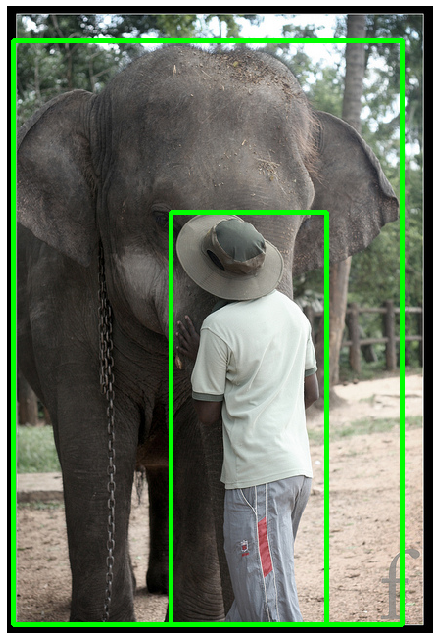

Image name: COCO_val2014_000000432258
We find 0 objects,
but actually there are 16 objects.


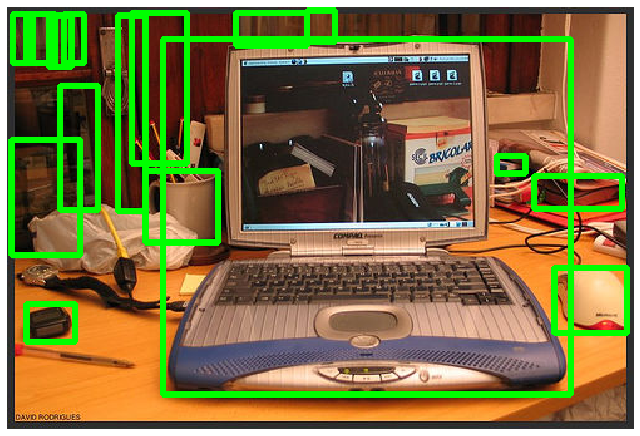

Image name: COCO_val2014_000000064146
We find 1 objects,
but actually there are 4 objects.


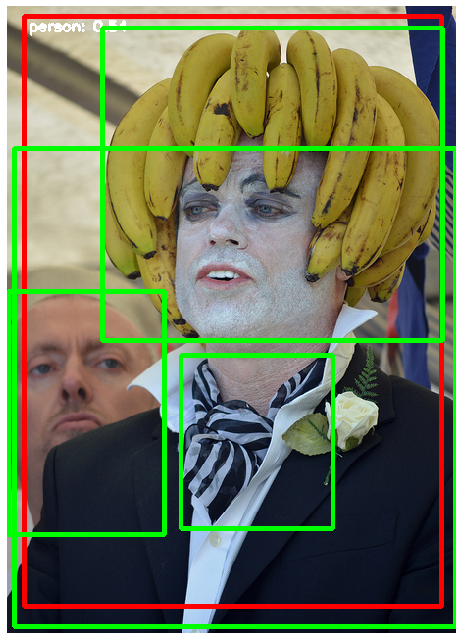

Image name: COCO_val2014_000000157269
We find 3 objects,
but actually there are 13 objects.


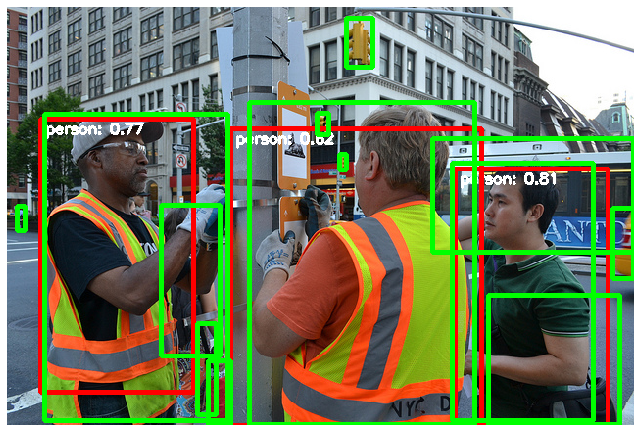

Image name: COCO_val2014_000000365387
We find 1 objects,
but actually there are 4 objects.


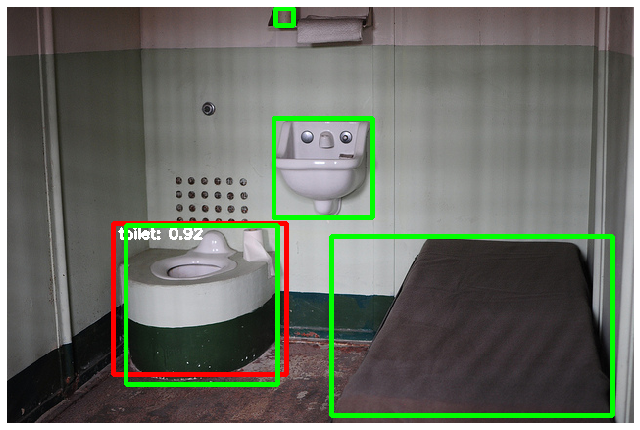

Image name: COCO_val2014_000000283520
We find 2 objects,
but actually there are 4 objects.


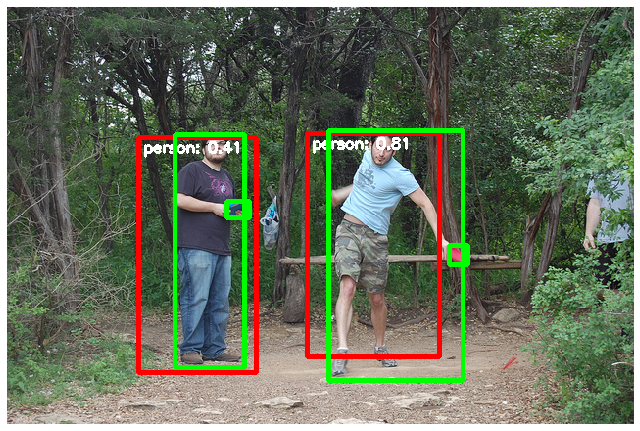

Image name: COCO_val2014_000000386500
We find 0 objects,
but actually there are 2 objects.


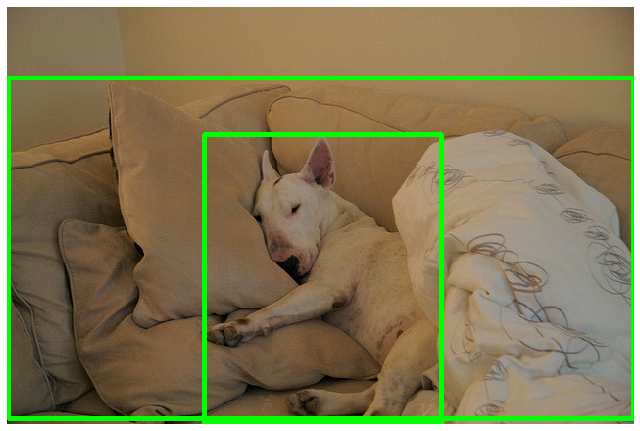

Image name: COCO_val2014_000000045864
We find 6 objects,
but actually there are 12 objects.


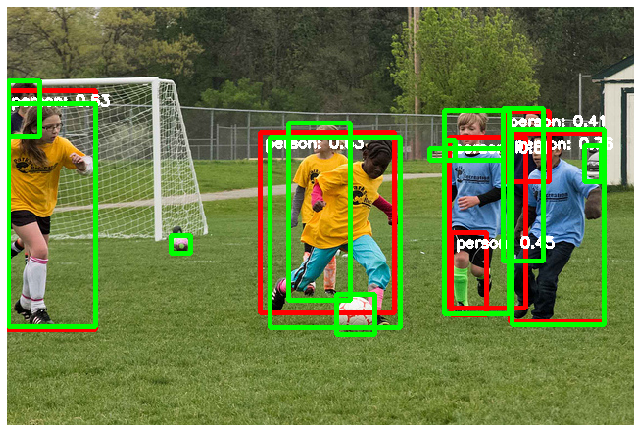

Image name: COCO_val2014_000000182784
We find 0 objects,
but actually there are 39 objects.


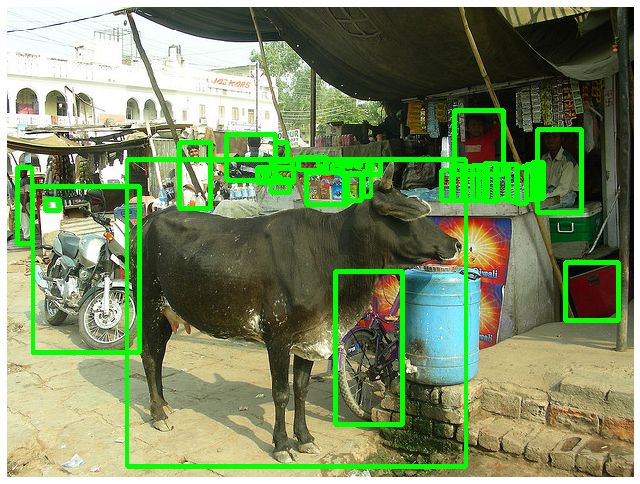

Image name: COCO_val2014_000000385514
We find 3 objects,
but actually there are 9 objects.


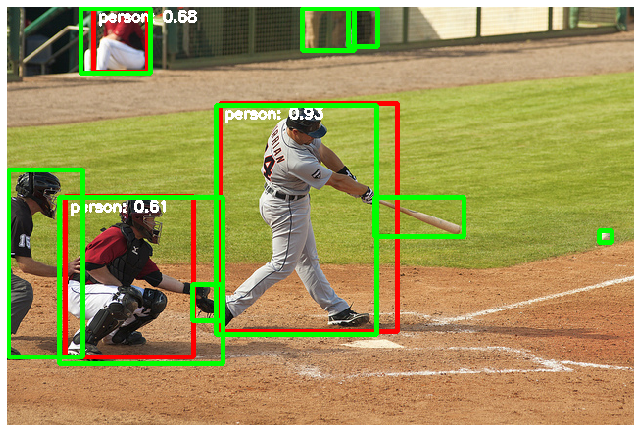

In [1]:
from utils.image_print import image_print

%matplotlib inline


net_type = "vgg16-ssd"
model_path = "models/vgg16-ssd-Epoch-41-Loss-6.00054.pth"
label_path = "models/coco-model-labels.txt"
data_dir = "/home/taeho/data/coco2014/"
test_txt = "/home/taeho/data/coco2014/images/test.txt"
how_many_images = 10

print("Use model:", model_path, "\n")
image_print(net_type=net_type,
            model_path=model_path,
            label_path=label_path,
            data_dir=data_dir,
            test_txt=test_txt,
            how_many_images=how_many_images)